In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = "images"

In [2]:
def display(output, cpu = True):
    img1 = output[0].at(0) if cpu else output[0].as_cpu().at(0)
    img2 = output[1].at(0) if cpu else output[1].as_cpu().at(0)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img1);
    ax[1].imshow(img2);

In [3]:
class HsvCpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvCpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.input = ops.FileReader(device="cpu",file_root=image_filename)
        self.decode = ops.ImageDecoder(device = "cpu", output_type = types.RGB)
        self.hsv = ops.Hsv(device = "cpu", hue_delta = 30, saturation_delta = 1, value_delta = .6, output_type = types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image)
        return image, converted
    
class HsvGpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super(HsvGpuPipeline, self).__init__(batch_size, num_threads, device_id, seed=12)
        self.input = ops.FileReader(device = "cpu",file_root=image_filename)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.hsv = ops.Hsv(device = "gpu", hue_delta = -30, saturation_delta = 1, value_delta = .6, output_type = types.RGB)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image.gpu())
        return image, converted

In [4]:
pipegpu = HsvGpuPipeline(batch_size=batch_size, num_threads=1, device_id = 0)
pipegpu.build()          
gpu_output = pipegpu.run()


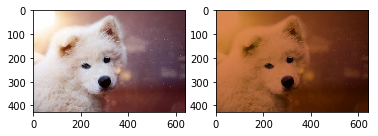

In [8]:
display(gpu_output, cpu = False)

In [6]:
pipecpu = HsvCpuPipeline(batch_size=batch_size, num_threads=1, device_id = 0)
pipecpu.build()          
cpu_output = pipecpu.run()

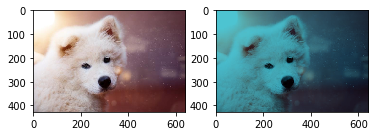

In [7]:
display(cpu_output)